# Análise e Tratamento de Dados

In [280]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns,plotly.graph_objects as go
from scipy.stats import spearmanr

In [281]:
btc = pd.read_csv('cryptocompare.csv')

In [282]:
fig = go.Figure(data=[go.Candlestick(x=btc['timestamp'][:],
                open=btc['open'], high=btc['high'],
                low=btc['low'], close=btc['close'])
                     ])

fig.update_layout(xaxis_rangeslider_visible=True, title='BTC por Hora com Range Slider')
fig.show();

Acima ilustramos a base extraída de BTC ao longo de todo período coletado. Os dados foram compilados por hora.
Percebemos oscilações drásticas mesmo dentro do mesmo dia, em particular se utilizamos o Range Slide abaixo do gráfico para selecionar janela mais micro.

In [283]:
btc.drop(columns={'Unnamed: 0', 'conversionType', 'conversionSymbol'},inplace=True) #removendo colunas desnecessárias
btc.head()

,time,high,low,open,volumefrom,volumeto,close,timestamp
0,1630044000,47256.69,47058.45,47114.98,423.24,19962880.10,47185.31,2021-08-27 03:00:00
1,1630047600,47532.75,46869.74,47185.31,1711.68,80950148.88,47498.18,2021-08-27 04:00:00
2,1630051200,47562.46,47160.08,47498.18,622.15,29471791.61,47194.99,2021-08-27 05:00:00
3,1630054800,47330.90,47009.78,47194.99,552.13,26041401.74,47218.32,2021-08-27 06:00:00
4,1630058400,47486.71,47203.04,47218.32,930.42,44073510.90,47440.47,2021-08-27 07:00:00


In [284]:
btc_.close.describe()[-5:]

min    40511.11
25%    44433.00
50%    47309.44
75%    48692.74
max    55345.85
Name: close, dtype: float64

O intervalo da série coletada de variação por hora de Bitcoin fica entre 40.511 e 55.345.

Entendendo os dados extraídos dos tweets:

In [285]:
tweets = pd.read_csv("db_tweets.csv")
tweets.head()

,date,sentiment
0,2021-10-02 20:00:00+00:00,6.845264e+06
1,2021-10-02 21:00:00+00:00,9.881929e+10
2,2021-10-02 22:00:00+00:00,3.106419e+09
3,2021-10-02 23:00:00+00:00,2.753322e+11
4,2021-10-03 00:00:00+00:00,2.698743e+10


In [286]:
tweets.tail()

,date,sentiment
102,2021-10-07 02:00:00+00:00,4.566834e+11
103,2021-10-07 03:00:00+00:00,3.651994e+10
104,2021-10-07 04:00:00+00:00,1.303323e+11
105,2021-10-07 05:00:00+00:00,2.002630e+08
106,2021-10-07 06:00:00+00:00,3.294129e+10


A base de tweets já foi tratada e classificada com sentimento dos tweets por hora.

Text(0.5, 1.0, 'Somatória de Sentimentos (VADER) por hora desde 02-Out')

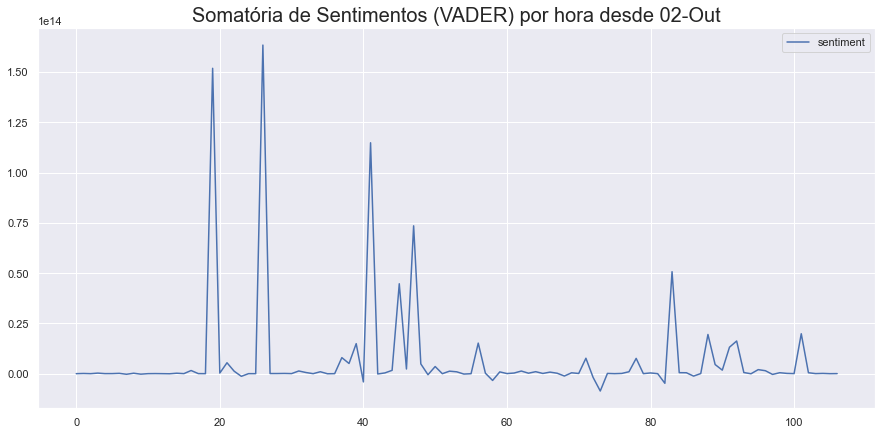

In [287]:
sns.set()
plt.figure(figsize = (15,7))
sns.lineplot(data=tweets)
plt.title('Somatória de Sentimentos (VADER) por hora desde 02-Out', fontsize = 20);


Acima temos a variação de polarização de sentimentos entre o dia 2 e o dia 7 de Outubro.
Comparando com a oscilação do Bitcoin:

In [288]:
# Abaixo fazemos ajuste de UTC para que as duas tabelas se conversem em data e timestamp
btc.timestamp = pd.to_datetime(btc.timestamp, utc=True)
tweets.date = pd.to_datetime(tweets.date, utc=True)

# Abaixo usamos um INNER JOIN para bater os horários com os preços do BTC e sentimento correspondente no Twitter:
df=btc.merge(tweets,left_on='timestamp', right_on='date')
df.drop(columns={'date','time'},inplace=True)
df.set_index('timestamp',inplace=True)

# Adicionando variação de close:
# Se subiu em relação ao fechamento anterior = 1, caso contrário = 0
df['direc'] = df['close']-df['close'].shift(1)
df.head()

,high,low,open,volumefrom,volumeto,close,sentiment,direc
timestamp,,,,,,,,
2021-10-02 20:00:00+00:00,48190.20,47535.00,48087.25,939.58,44917457.99,47669.02,6.845264e+06,NaN
2021-10-02 21:00:00+00:00,47821.30,47137.07,47669.02,1704.46,80845122.16,47309.44,9.881929e+10,-359.58
2021-10-02 22:00:00+00:00,47632.02,47264.65,47309.44,730.36,34629968.38,47557.04,3.106419e+09,247.60
2021-10-02 23:00:00+00:00,47774.71,47529.19,47557.04,490.94,23406151.41,47655.00,2.753322e+11,97.96
2021-10-03 00:00:00+00:00,47968.09,47582.53,47655.00,503.12,24020067.70,47923.49,2.698743e+10,268.49


No handles with labels found to put in legend.


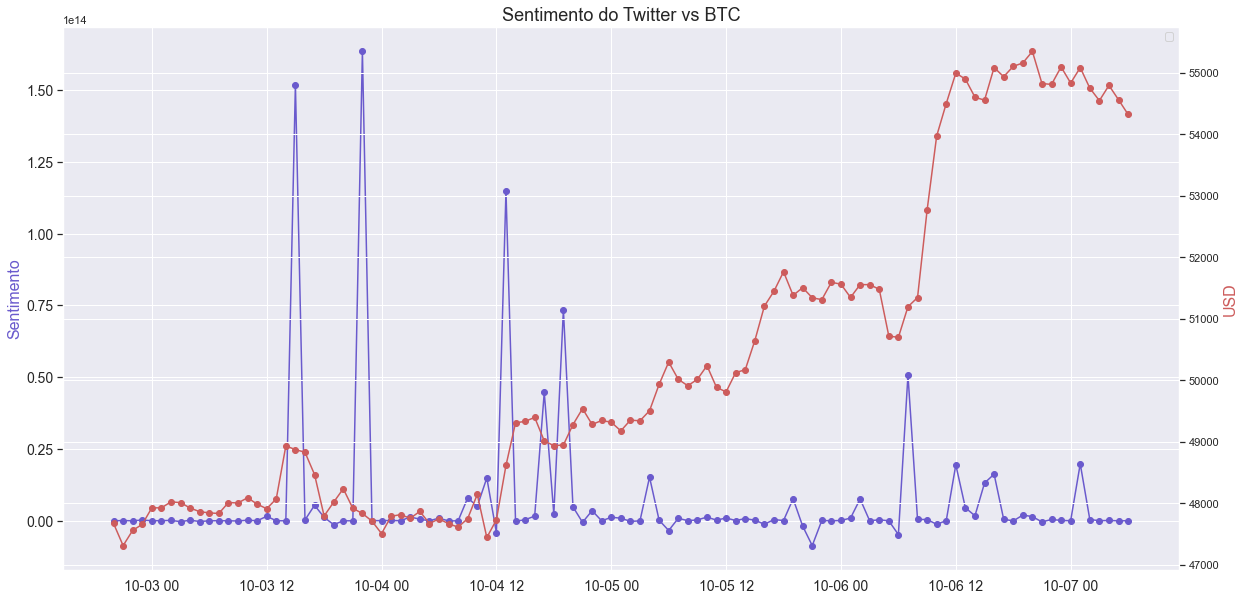

In [289]:
sns.set()
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.set_title("Sentimento do Twitter vs BTC", fontsize=18)
ax1.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot_date(df.index, df.sentiment, color='slateblue', ls='-')
ax2.plot_date(df.index, df.close, color='indianred', ls='-')

ax1.set_ylabel("Sentimento", color='slateblue', fontsize=16)
ax2.set_ylabel("USD", color='indianred', fontsize=16)
plt.legend()
plt.show();

Parece haver relação entre picos de sentimentos do twitter com escaladas nos preços de bitcoin.
Abaixo medimos as correlações:

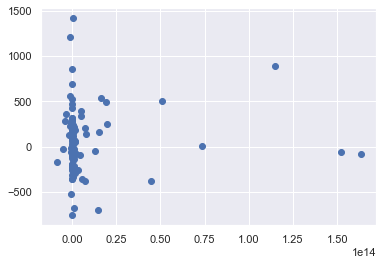

In [290]:
# Scatterplot:
plt.scatter(df.sentiment, df.direc);

In [298]:
# Acima parece haver correlação, abaixo calculamos a linear e de spearman:
df[['direc','close']].corr()

,direc,close
direc,1.000000,0.117686
close,0.117686,1.000000


In [300]:
spearmanr(df['direc'], df['close'])

SpearmanrResult(correlation=nan, pvalue=nan)

Acima temos uma correlação linear de Pearson de 0.11.

# XGBoosting

In [293]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [301]:
# Separando em teste e treinamento
p = 0.2 # 20% teste, 80% treino
X = np.array(df.direc).reshape(-1,1)
y = np.array(df.close).reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = p)

In [303]:
# Definindo Modelo XGBoost para regressão
my_params = {'objective':'reg:squarederror', 'verbose':False, 'n_estimators': 500, 'max_depth': 4}

model = xgb.XGBRegressor(**my_params)

model.fit(x_train, y_train)
# poly_features= PolynomialFeatures(degree=4) #tentamos polyfeatures também
# xtrain = poly_features.fit_transform(x_train)
# model = LinearRegression()
# Treinando
model.fit(x_train, y_train)

# Prevendo para test set
y_pred = model.predict(x_test).reshape(-1,1)

[07:50:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:50:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




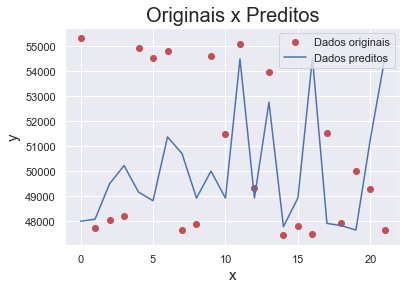

In [304]:
# Visualizando previsão:
plt.plot(y_test, 'ro', label='Dados originais')
plt.plot(y_pred, 'b-', label = 'Dados preditos')
plt.ylabel("y", fontsize=15)
plt.xlabel("x", fontsize=15)
plt.legend()
plt.title('Originais x Preditos', fontsize = 20)
plt.show(True);

In [305]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RSME = mean_squared_error(y_test, y_pred)
print("RSME:", RSME)

R2 = r2_score(y_test, y_pred)
print('R2:', R2)


RSME: 13572299.492219811
R2: -0.4451783959394229


Percebemos uma performance negativa ara prever a variação do BTC.
E se trocarmos para um classificador direcional?